In [5]:
import os

import PIL
from PIL import Image
from PIL.ImageDraw import Draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from scipy.ndimage import affine_transform
from keras import backend as K

import pandas as pd
from tqdm import tqdm

In [7]:
MODEL_BASE = '../data/whale/bounding-box-model'
DATA = '../data/whale'
TRAIN = os.path.join(DATA, 'train')
TEST = os.path.join(DATA, 'test')
CROP = os.path.join(DATA, 'cropping.txt')

In [10]:
with open(CROP, 'rt') as f: 
    data = f.read().split('\n')[:-1]
data = [line.split(',') for line in data]
data = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in data]
data[0] 

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

In [11]:
from os.path import isfile

In [18]:
def expand_path(p):
    if isfile(os.path.join(TRAIN, p)): return os.path.join(TRAIN, p)
    if isfile(os.path.join(TEST, p)): return os.path.join(TEST, p)
    return p

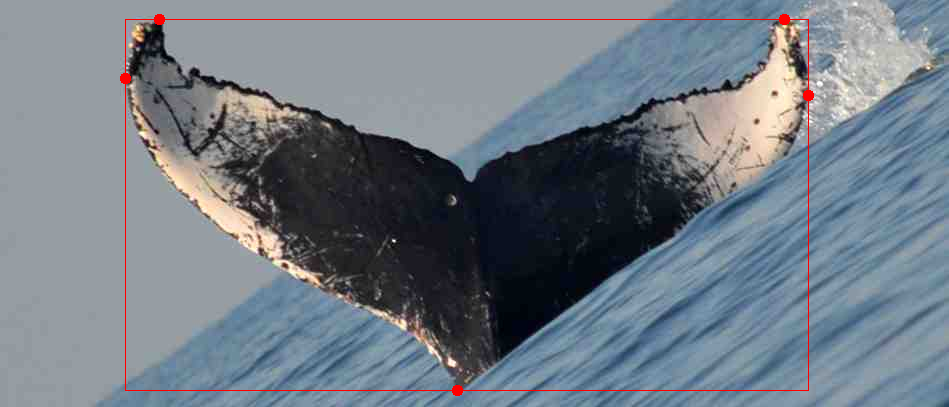

In [22]:
def read_raw_image(p):
    return Image.open(expand_path(p))

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1

filename,coordinates = data[1]
box = bounding_rectangle(coordinates)
img = read_raw_image(filename)
draw = Draw(img)
draw_dots(draw, coordinates)
draw.rectangle(box, outline='red')
img

In [20]:
os.path.join(TRAIN, '88532e70.jpg')

'../data/whale\\train\\88532e70.jpg'

In [23]:
# Define useful constants
img_shape  = (128,128,1)
anisotropy = 2.15

In [24]:
import random
import numpy as np
from scipy.ndimage import affine_transform
from keras.preprocessing.image import img_to_array

In [25]:
# Read an image as black&white numpy array
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

In [26]:
def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

In [27]:
# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))


In [28]:
# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)


In [29]:
# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

In [30]:
# Read an image for training, i.e. including a random affine transformation
def read_for_training(p):
    x  = read_array(p)
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

In [31]:
# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

In [33]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=200, random_state=1)
train += train
train += train
train += train
train += train
len(train),len(val)

(16000, 200)

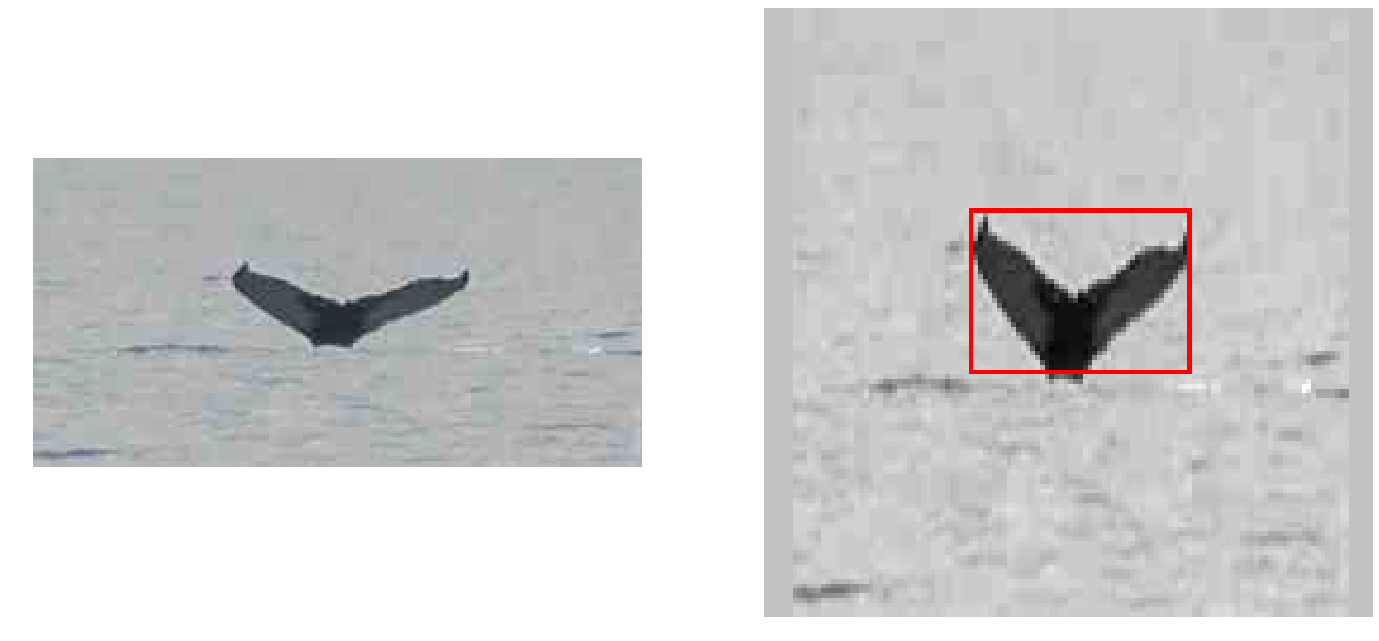

In [34]:
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from keras import backend as K
from keras.preprocessing.image import array_to_img
from numpy.linalg import inv as mat_inv

def show_whale(imgs, per_row=5):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

val_a = np.zeros((len(val),)+img_shape,dtype=K.floatx()) # Preprocess validation images 
val_b = np.zeros((len(val),4),dtype=K.floatx()) # Preprocess bounding boxes
for i,(p,coords) in enumerate(tqdm_notebook(val)):
    img,trans      = read_for_validation(p)
    coords         = coord_transform(coords, mat_inv(trans))
    x0,y0,x1,y1    = bounding_rectangle(coords)
    val_a[i,:,:,:] = img
    val_b[i,0]     = x0
    val_b[i,1]     = y0
    val_b[i,2]     = x1
    val_b[i,3]     = y1

idx  = 1
img  = array_to_img(val_a[idx])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(val_b[idx], outline='red')
show_whale([read_raw_image(val[idx][0]), img], per_row=2)

In [41]:
from keras.utils import Sequence

class TrainingData(Sequence):
    def __init__(self,batch_size=32):
        super(TrainingData,self).__init__()
        self.batch_size = batch_size
    def __getitem__(self,index):
        start = self.batch_size*index
        end = min(len(train),start+self.batch_size)
        size = end -start
        a = np.zeros((size,)+ img_shape,dtype=K.floatx())
        b = np.zeros((size,4),dtype=K.floatx())
        for i,(p,coords) in enumerate(train[start:end]):
            img,trans = read_for_training(p)
            coords = coord_transform(coords,mat_inv(trans))
            x0,y0,x1,y1 = bounding_rectangle(coords)
            a[i,:,:,:] = img
            b[i,0] = x0
            b[i,1] = y0
            b[i,2] = x1
            b[i,3] = y1
        return a,b
    def __len__(self):
        return (len(train) + self.batch_size - 1)//self.batch_size

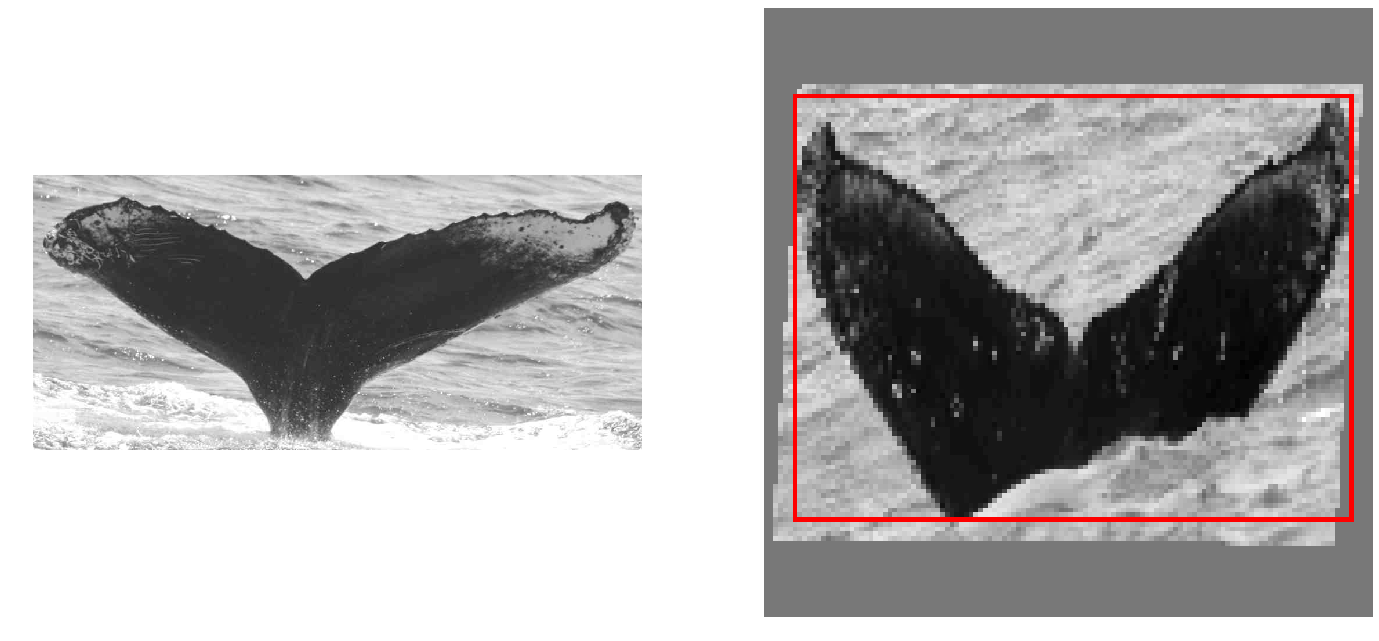

In [42]:
random.seed(1)
a,b = TrainingData(batch_size=5)[1]
img = array_to_img(a[0])
img = img.convert('RGB')
draw = Draw(img)
draw.rectangle(b[0],outline='red')
show_whale([read_raw_image(train[0][0]),img], per_row=2)

In [43]:
from keras.engine.topology import Input
from keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model

In [45]:
def build_model(with_dropout = True):
    kwargs = {'activation':'relu', 'padding':'same'}
    conv_drop = 0.2
    dense_drop = 0.5
    inp = Input(shape=img_shape)
    
    x = inp
    
    x = Conv2D(64,(9,9),**kwargs)(x)
    x = Conv2D(64,(3,3),**kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)
    
    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    x = Dense(4, activation='linear')(x)
    return Model(inp,x)

model = build_model(with_dropout=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

dropout_9 (Dropout)             (None, 32)           0           concatenate_1[0][0]              
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            132         dropout_9[0][0]                  
Total params: 503,588
Trainable params: 502,820
Non-trainable params: 768
__________________________________________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

for num in range(1, 4):
    model_name = 'cropping-%01d.h5' % num
    print(model_name)
    model.compile(Adam(lr=0.032), loss='mean_squared_error')
    model.fit_generator(
        TrainingData(), epochs=50, max_queue_size=12, workers=4, verbose=1,
        validation_data=(val_a, val_b),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=9, min_delta=0.1, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.1, factor=0.25, min_lr=0.002, verbose=1),
            ModelCheckpoint(model_name, save_best_only=True, save_weights_only=True),
        ])
    model.load_weights(model_name)
    model.evaluate(val_a, val_b, verbose=0)

cropping-1.h5
Epoch 1/50


301/500 [=================>............] - ETA: 40:03 - loss: 5785.227 - ETA: 20:36 - loss: 5227.068 - ETA: 14:05 - loss: 4426.871 - ETA: 10:50 - loss: 3668.921 - ETA: 8:51 - loss: 3310.296 - ETA: 7:33 - loss: 2916.68 - ETA: 6:37 - loss: 2605.15 - ETA: 5:55 - loss: 2393.10 - ETA: 5:23 - loss: 2214.37 - ETA: 4:56 - loss: 2086.96 - ETA: 4:35 - loss: 1997.12 - ETA: 4:17 - loss: 1914.32 - ETA: 4:02 - loss: 1827.12 - ETA: 3:49 - loss: 1771.36 - ETA: 3:37 - loss: 1709.25 - ETA: 3:28 - loss: 1654.07 - ETA: 3:19 - loss: 1611.55 - ETA: 3:12 - loss: 1581.14 - ETA: 3:05 - loss: 1536.37 - ETA: 2:58 - loss: 1493.19 - ETA: 2:52 - loss: 1461.47 - ETA: 2:47 - loss: 1424.10 - ETA: 2:43 - loss: 1395.15 - ETA: 2:38 - loss: 1363.71 - ETA: 2:34 - loss: 1344.02 - ETA: 2:30 - loss: 1317.39 - ETA: 2:27 - loss: 1294.12 - ETA: 2:24 - loss: 1275.38 - ETA: 2:21 - loss: 1258.64 - ETA: 2:18 - loss: 1236.13 - ETA: 2:15 - loss: 1217.01 - ETA: 2:13 - loss: 1208.86 - ETA: 2:10 - loss: 1196.53 - ETA: 2:08 - loss: 1182.1

500/500 [==============================] - ETA: 30s - loss: 658.71 - ETA: 30s - loss: 657.89 - ETA: 30s - loss: 657.05 - ETA: 30s - loss: 656.61 - ETA: 30s - loss: 655.88 - ETA: 29s - loss: 655.01 - ETA: 29s - loss: 654.24 - ETA: 29s - loss: 654.03 - ETA: 29s - loss: 653.44 - ETA: 29s - loss: 652.95 - ETA: 29s - loss: 652.51 - ETA: 28s - loss: 651.50 - ETA: 28s - loss: 650.85 - ETA: 28s - loss: 650.02 - ETA: 28s - loss: 649.48 - ETA: 28s - loss: 648.85 - ETA: 28s - loss: 648.17 - ETA: 27s - loss: 647.23 - ETA: 27s - loss: 646.57 - ETA: 27s - loss: 645.66 - ETA: 27s - loss: 644.85 - ETA: 27s - loss: 644.08 - ETA: 27s - loss: 643.50 - ETA: 26s - loss: 643.12 - ETA: 26s - loss: 642.36 - ETA: 26s - loss: 641.72 - ETA: 26s - loss: 640.89 - ETA: 26s - loss: 640.31 - ETA: 26s - loss: 639.76 - ETA: 26s - loss: 638.99 - ETA: 25s - loss: 638.45 - ETA: 25s - loss: 637.68 - ETA: 25s - loss: 636.92 - ETA: 25s - loss: 636.23 - ETA: 25s - loss: 635.35 - ETA: 25s - loss: 634.49 - ETA: 24s - loss: 634.

309/500 [=================>............] - ETA: 1:06 - loss: 325.373 - ETA: 1:06 - loss: 330.312 - ETA: 1:09 - loss: 328.606 - ETA: 1:08 - loss: 342.621 - ETA: 1:07 - loss: 339.412 - ETA: 1:07 - loss: 343.511 - ETA: 1:08 - loss: 357.535 - ETA: 1:07 - loss: 360.360 - ETA: 1:07 - loss: 350.331 - ETA: 1:07 - loss: 358.068 - ETA: 1:07 - loss: 350.858 - ETA: 1:07 - loss: 347.459 - ETA: 1:07 - loss: 345.947 - ETA: 1:07 - loss: 347.790 - ETA: 1:07 - loss: 350.644 - ETA: 1:07 - loss: 360.650 - ETA: 1:07 - loss: 359.039 - ETA: 1:06 - loss: 361.162 - ETA: 1:06 - loss: 371.012 - ETA: 1:06 - loss: 379.051 - ETA: 1:06 - loss: 373.515 - ETA: 1:06 - loss: 373.319 - ETA: 1:06 - loss: 377.441 - ETA: 1:06 - loss: 386.363 - ETA: 1:06 - loss: 387.852 - ETA: 1:05 - loss: 385.803 - ETA: 1:05 - loss: 382.719 - ETA: 1:05 - loss: 381.507 - ETA: 1:05 - loss: 383.043 - ETA: 1:05 - loss: 383.842 - ETA: 1:05 - loss: 385.034 - ETA: 1:05 - loss: 385.445 - ETA: 1:05 - loss: 386.547 - ETA: 1:05 - loss: 391.820 - ETA: 

500/500 [==============================] - ETA: 26s - loss: 362.79 - ETA: 26s - loss: 362.40 - ETA: 26s - loss: 362.37 - ETA: 26s - loss: 362.54 - ETA: 25s - loss: 362.17 - ETA: 25s - loss: 362.17 - ETA: 25s - loss: 362.24 - ETA: 25s - loss: 362.40 - ETA: 25s - loss: 362.67 - ETA: 25s - loss: 362.41 - ETA: 25s - loss: 362.80 - ETA: 24s - loss: 363.02 - ETA: 24s - loss: 363.20 - ETA: 24s - loss: 363.14 - ETA: 24s - loss: 363.03 - ETA: 24s - loss: 363.06 - ETA: 24s - loss: 362.83 - ETA: 24s - loss: 362.80 - ETA: 24s - loss: 362.71 - ETA: 23s - loss: 362.53 - ETA: 23s - loss: 362.25 - ETA: 23s - loss: 361.86 - ETA: 23s - loss: 361.89 - ETA: 23s - loss: 362.09 - ETA: 23s - loss: 361.73 - ETA: 23s - loss: 361.53 - ETA: 22s - loss: 361.49 - ETA: 22s - loss: 361.31 - ETA: 22s - loss: 361.21 - ETA: 22s - loss: 361.28 - ETA: 22s - loss: 360.93 - ETA: 22s - loss: 360.60 - ETA: 22s - loss: 360.63 - ETA: 21s - loss: 360.60 - ETA: 21s - loss: 360.35 - ETA: 21s - loss: 360.33 - ETA: 21s - loss: 360.

308/500 [=================>............] - ETA: 1:04 - loss: 370.709 - ETA: 1:07 - loss: 379.118 - ETA: 1:08 - loss: 376.188 - ETA: 1:07 - loss: 353.338 - ETA: 1:08 - loss: 334.344 - ETA: 1:09 - loss: 322.666 - ETA: 1:08 - loss: 327.772 - ETA: 1:08 - loss: 314.101 - ETA: 1:08 - loss: 320.272 - ETA: 1:08 - loss: 315.793 - ETA: 1:08 - loss: 313.886 - ETA: 1:08 - loss: 317.340 - ETA: 1:07 - loss: 313.258 - ETA: 1:08 - loss: 310.911 - ETA: 1:07 - loss: 313.653 - ETA: 1:07 - loss: 314.389 - ETA: 1:07 - loss: 315.245 - ETA: 1:07 - loss: 314.121 - ETA: 1:07 - loss: 313.081 - ETA: 1:07 - loss: 312.392 - ETA: 1:07 - loss: 311.509 - ETA: 1:07 - loss: 310.287 - ETA: 1:06 - loss: 313.418 - ETA: 1:06 - loss: 313.506 - ETA: 1:06 - loss: 314.294 - ETA: 1:06 - loss: 312.213 - ETA: 1:06 - loss: 312.875 - ETA: 1:06 - loss: 315.482 - ETA: 1:06 - loss: 313.592 - ETA: 1:05 - loss: 313.624 - ETA: 1:05 - loss: 312.500 - ETA: 1:05 - loss: 310.248 - ETA: 1:05 - loss: 308.990 - ETA: 1:05 - loss: 309.405 - ETA: 

500/500 [==============================] - ETA: 26s - loss: 323.97 - ETA: 26s - loss: 323.87 - ETA: 26s - loss: 323.75 - ETA: 26s - loss: 323.90 - ETA: 26s - loss: 323.93 - ETA: 26s - loss: 324.04 - ETA: 25s - loss: 324.00 - ETA: 25s - loss: 324.30 - ETA: 25s - loss: 324.28 - ETA: 25s - loss: 324.21 - ETA: 25s - loss: 324.31 - ETA: 25s - loss: 324.47 - ETA: 25s - loss: 324.58 - ETA: 24s - loss: 324.22 - ETA: 24s - loss: 324.48 - ETA: 24s - loss: 324.18 - ETA: 24s - loss: 324.39 - ETA: 24s - loss: 324.19 - ETA: 24s - loss: 324.14 - ETA: 24s - loss: 324.18 - ETA: 23s - loss: 324.71 - ETA: 23s - loss: 324.80 - ETA: 23s - loss: 325.05 - ETA: 23s - loss: 325.30 - ETA: 23s - loss: 325.22 - ETA: 23s - loss: 325.04 - ETA: 23s - loss: 325.09 - ETA: 22s - loss: 324.90 - ETA: 22s - loss: 325.06 - ETA: 22s - loss: 325.01 - ETA: 22s - loss: 325.26 - ETA: 22s - loss: 325.48 - ETA: 22s - loss: 325.57 - ETA: 22s - loss: 325.84 - ETA: 21s - loss: 325.88 - ETA: 21s - loss: 325.83 - ETA: 21s - loss: 325.

308/500 [=================>............] - ETA: 1:01 - loss: 328.691 - ETA: 1:07 - loss: 302.884 - ETA: 1:07 - loss: 304.462 - ETA: 1:09 - loss: 300.653 - ETA: 1:09 - loss: 320.468 - ETA: 1:08 - loss: 325.940 - ETA: 1:08 - loss: 320.889 - ETA: 1:08 - loss: 312.457 - ETA: 1:08 - loss: 315.495 - ETA: 1:08 - loss: 314.946 - ETA: 1:08 - loss: 309.409 - ETA: 1:08 - loss: 317.939 - ETA: 1:08 - loss: 314.377 - ETA: 1:08 - loss: 316.250 - ETA: 1:08 - loss: 320.727 - ETA: 1:08 - loss: 324.593 - ETA: 1:07 - loss: 323.490 - ETA: 1:07 - loss: 322.197 - ETA: 1:07 - loss: 320.651 - ETA: 1:07 - loss: 319.808 - ETA: 1:07 - loss: 319.149 - ETA: 1:07 - loss: 323.184 - ETA: 1:07 - loss: 320.283 - ETA: 1:06 - loss: 328.445 - ETA: 1:06 - loss: 332.572 - ETA: 1:06 - loss: 329.470 - ETA: 1:06 - loss: 326.424 - ETA: 1:06 - loss: 324.271 - ETA: 1:06 - loss: 322.752 - ETA: 1:06 - loss: 321.465 - ETA: 1:05 - loss: 320.368 - ETA: 1:05 - loss: 318.405 - ETA: 1:05 - loss: 319.422 - ETA: 1:05 - loss: 322.330 - ETA: 

500/500 [==============================] - ETA: 26s - loss: 311.01 - ETA: 26s - loss: 311.38 - ETA: 26s - loss: 311.18 - ETA: 26s - loss: 311.33 - ETA: 26s - loss: 311.29 - ETA: 25s - loss: 311.45 - ETA: 25s - loss: 311.25 - ETA: 25s - loss: 311.35 - ETA: 25s - loss: 311.26 - ETA: 25s - loss: 311.07 - ETA: 25s - loss: 310.86 - ETA: 25s - loss: 310.89 - ETA: 24s - loss: 310.73 - ETA: 24s - loss: 310.71 - ETA: 24s - loss: 310.85 - ETA: 24s - loss: 310.92 - ETA: 24s - loss: 310.85 - ETA: 24s - loss: 310.85 - ETA: 24s - loss: 310.97 - ETA: 23s - loss: 310.68 - ETA: 23s - loss: 310.43 - ETA: 23s - loss: 310.72 - ETA: 23s - loss: 310.99 - ETA: 23s - loss: 311.04 - ETA: 23s - loss: 311.36 - ETA: 23s - loss: 311.31 - ETA: 23s - loss: 311.14 - ETA: 22s - loss: 311.06 - ETA: 22s - loss: 310.98 - ETA: 22s - loss: 310.90 - ETA: 22s - loss: 310.60 - ETA: 22s - loss: 310.62 - ETA: 22s - loss: 310.43 - ETA: 22s - loss: 310.30 - ETA: 21s - loss: 310.07 - ETA: 21s - loss: 310.21 - ETA: 21s - loss: 310.

309/500 [=================>............] - ETA: 1:07 - loss: 274.846 - ETA: 1:08 - loss: 259.923 - ETA: 1:08 - loss: 259.381 - ETA: 1:07 - loss: 262.670 - ETA: 1:08 - loss: 263.028 - ETA: 1:07 - loss: 268.722 - ETA: 1:07 - loss: 263.575 - ETA: 1:08 - loss: 267.471 - ETA: 1:08 - loss: 273.747 - ETA: 1:08 - loss: 269.975 - ETA: 1:08 - loss: 266.959 - ETA: 1:07 - loss: 269.804 - ETA: 1:07 - loss: 269.485 - ETA: 1:07 - loss: 270.027 - ETA: 1:07 - loss: 272.860 - ETA: 1:07 - loss: 275.456 - ETA: 1:07 - loss: 277.722 - ETA: 1:07 - loss: 278.296 - ETA: 1:07 - loss: 277.890 - ETA: 1:07 - loss: 279.193 - ETA: 1:07 - loss: 281.902 - ETA: 1:06 - loss: 281.739 - ETA: 1:06 - loss: 284.737 - ETA: 1:06 - loss: 283.220 - ETA: 1:06 - loss: 283.095 - ETA: 1:06 - loss: 281.074 - ETA: 1:06 - loss: 279.423 - ETA: 1:05 - loss: 280.018 - ETA: 1:06 - loss: 281.630 - ETA: 1:05 - loss: 282.054 - ETA: 1:05 - loss: 284.444 - ETA: 1:05 - loss: 286.022 - ETA: 1:05 - loss: 285.269 - ETA: 1:05 - loss: 286.624 - ETA: 

428/500 [========================>.....] - ETA: 26s - loss: 278.56 - ETA: 26s - loss: 278.62 - ETA: 26s - loss: 278.45 - ETA: 26s - loss: 278.38 - ETA: 26s - loss: 278.30 - ETA: 25s - loss: 278.07 - ETA: 25s - loss: 277.93 - ETA: 25s - loss: 277.83 - ETA: 25s - loss: 277.65 - ETA: 25s - loss: 277.72 - ETA: 25s - loss: 277.61 - ETA: 25s - loss: 277.49 - ETA: 24s - loss: 277.35 - ETA: 24s - loss: 277.48 - ETA: 24s - loss: 277.42 - ETA: 24s - loss: 277.26 - ETA: 24s - loss: 277.25 - ETA: 24s - loss: 276.94 - ETA: 24s - loss: 276.87 - ETA: 23s - loss: 276.85 - ETA: 23s - loss: 276.68 - ETA: 23s - loss: 276.64 - ETA: 23s - loss: 276.76 - ETA: 23s - loss: 276.65 - ETA: 23s - loss: 277.04 - ETA: 23s - loss: 276.99 - ETA: 22s - loss: 277.14 - ETA: 22s - loss: 277.14 - ETA: 22s - loss: 276.99 - ETA: 22s - loss: 277.02 - ETA: 22s - loss: 276.99 - ETA: 22s - loss: 276.77 - ETA: 22s - loss: 276.82 - ETA: 21s - loss: 276.65 - ETA: 21s - loss: 276.55 - ETA: 21s - loss: 276.47 - ETA: 21s - loss: 276.